Importing necessary data

In [13]:
import tweepy
import csv
import time
import pandas as pd
import re
from pymongo import MongoClient
from textblob import TextBlob
from vaderSentiment.vaderSentiment import SentimentIntensityAnalyzer
import matplotlib.pyplot as plt
from matplotlib.dates import DateFormatter as DF

Identify keywords related to AI 

In [16]:
ai_keywords = [
    "AI", 
    "Artificial Intelligence", 
    "Chatgpt", 
    "Deepseek", 
    "CV",
     "NLP"
]

# Data Extraction

Requsting tweets using tweepy

In [20]:
bearer_token = r"AAAAAAAAAAAAAAAAAAAAACem0QEAAAAA9K9IjdQq7CVknHf3LU%2BdL1eDLNI%3DyqoIN7ulbPn9IeOxbAp53Nuh02HE8onASZcbBtApKzwn2TGeRP"

In [22]:
client = tweepy.Client(bearer_token= bearer_token)

Reading tweets

In [27]:
import os
file_path = "ai_tweets.csv"
write_header = not os.path.exists(file_path) or os.path.getsize(file_path) == 0

with open(file_path, 'a', newline='', encoding='utf-8-sig') as file:
    writer = csv.writer(file)

    if write_header:
        writer.writerow(['Tweet', 'created_at'])

    for keyword in ai_keywords:
        try:
            tweets = client.search_recent_tweets(
                query=f'"{keyword}" lang:en -is:retweet',
                max_results=10,
                tweet_fields=['created_at', 'text']
            )

            if tweets.data:
                for tweet in tweets.data:
                    writer.writerow([tweet.text, tweet.created_at])
            time.sleep(10)

        except Exception as e:
            print(f'Error fetching for {keyword} : ', e)

Error fetching for Artificial Intelligence :  429 Too Many Requests
Too Many Requests
Error fetching for Chatgpt :  429 Too Many Requests
Too Many Requests
Error fetching for Deepseek :  429 Too Many Requests
Too Many Requests
Error fetching for CV :  429 Too Many Requests
Too Many Requests
Error fetching for NLP :  429 Too Many Requests
Too Many Requests


Reading dataset

In [30]:
df = pd.read_csv("ai_tweets.csv", encoding='ISO-8859-1')
print(f"Total rows: {len(df)}")


Total rows: 151687


-----------------

# Cleaning

In [76]:
df = df[~df['created_at'].astype(str).str.contains("created_at", na=False)]
df['created_at'] = pd.to_datetime(df['created_at'], errors='coerce')
df = df[df['created_at'].notna()]

df.drop_duplicates(inplace=True)

df.dropna(subset=['Tweet', 'created_at'], inplace=True)


In [77]:
def clean_text(text):
    text = str(text)
    text = re.sub(r"http\S+", "", text)  
    text = re.sub(r"@\w+", "", text)    
    text = re.sub(r"#\w+", "", text)     
    text = re.sub(r"[^\w\s]", "", text)  
    text = re.sub(r"\s+", " ", text)     
    return text.strip().lower()

In [78]:
df['cleaned_text'] = df['Tweet'].apply(clean_text)
df.drop_duplicates(subset=['cleaned_text'], inplace=True)

df['Tweet'] = df['cleaned_text']
df.drop(columns=['cleaned_text'], inplace=True)

df.head()

,Tweet,created_at,vader_score,sentiment
0,invest in a currency that is designed to offer...,2025-03-14,0.5994,Positive
1,while having all the hope around chatgpt lets ...,2025-03-14,0.5523,Positive
2,join the movement towards a more sustainable a...,2025-03-14,0.7479,Positive
3,theres a snowstorm out so naturally i decided ...,2025-03-14,0.0000,Neutral
4,invest in a currency that offers a more secure...,2025-03-14,0.4005,Positive


In [79]:
df.shape

(123746, 4)

In [80]:
na_counts = df.isna().sum()
print(na_counts)

Tweet          0
created_at     0
vader_score    0
sentiment      0
dtype: int64


In [81]:
duplicate_counts = df.duplicated().sum()
duplicate_counts

0

Storing data to MongoDB after cleaning

In [83]:
from pymongo import MongoClient

client = MongoClient('mongodb://localhost:27017/')
db = client['ai_tweets_db']
collection = db['tweets']

data_dict = df.to_dict("records")

existing_tweets = set(doc['Tweet'] for doc in collection.find({}, {'Tweet': 1}))

new_tweets = [doc for doc in data_dict if doc['Tweet'] not in existing_tweets]

if new_tweets:
    collection.insert_many(new_tweets)
    print(f"{len(new_tweets)} new tweets inserted into MongoDB")
else:
    print("No new tweets to insert")

count = collection.count_documents({})
print(f"Total number of tweets in MongoDB: {count}")

1 new tweets inserted into MongoDB
Total number of tweets in MongoDB: 123747


Displaying number of docs

-------------

# Sentiment analysis

In [88]:
# loading data From MogoDB to DataFrame
df = pd.DataFrame(list(collection.find()))

In [89]:
if '_id' in df.columns: #removing ID column since it will cause an issue 
    df.drop(columns=['_id'], inplace=True)

In [90]:
vader = SentimentIntensityAnalyzer() #Initialize VADER

Functions for sentiment

In [92]:
def analyze_vader(txt):
    score = vader.polarity_scores(txt)
    return score['compound']

In [93]:
def analyze_textblob(txt):
    return TextBlob(txt).sentiment.polarity

Apply sentiment analysis

In [95]:
df['vader_score'] = df['Tweet'].apply(analyze_vader)
df['textblob_score'] = df['Tweet'].apply(analyze_textblob)

In [96]:
df.head(20)

,Tweet,created_at,vader_score,sentiment,textblob_score
0,invest in a currency that is designed to offer...,2025-03-14,0.5994,Positive,0.166667
1,while having all the hope around chatgpt lets ...,2025-03-14,0.5523,Positive,-0.125000
2,join the movement towards a more sustainable a...,2025-03-14,0.7479,Positive,0.233333
3,theres a snowstorm out so naturally i decided ...,2025-03-14,0.0000,Neutral,0.100000
4,invest in a currency that offers a more secure...,2025-03-14,0.4005,Positive,0.250000
5,robots will take over the world ððð,2025-03-14,0.0000,Neutral,0.000000
6,join the community of investors who are commit...,2025-03-14,0.5106,Positive,0.000000
7,âready to start saving lots of time with â max...,2025-03-14,0.7003,Positive,0.400000
8,not sure if wrote this articleâ,2025-03-14,-0.2411,Negative,-0.250000
9,news alert,2025-03-14,0.2960,Positive,0.000000


In [97]:
df.tail(20) 

,Tweet,created_at,vader_score,sentiment,textblob_score
123727,chatgpt helped me with my homework and now iâm...,2025-02-16,-0.1027,Negative,0.000000
123728,deepseek told me the truth i wasnât ready to h...,2025-04-15,0.7717,Positive,0.200000
123729,chatgpt is too good at answering questions is ...,2025-03-16,0.4404,Positive,0.150000
123730,deepseekâs out here changing my life with pred...,2025-02-05,0.0000,Neutral,0.000000
123731,chatgpt helped me plan my life but iâm still w...,2025-03-28,0.5499,Positive,0.000000
123732,deepseek saw my mistakes before i did itâs hon...,2025-03-12,-0.4385,Negative,0.800000
123733,chatgpt just made me realize iâve been living ...,2025-03-31,0.0000,Neutral,0.000000
123734,deepseek knows more about trends than i do iâm...,2025-02-09,0.0000,Neutral,0.500000
123735,chatgpt is basically a walking talking brain i...,2025-03-30,0.4019,Positive,0.000000
123736,deepseekâs predictions are so accurate iâm sta...,2025-02-15,0.0000,Neutral,0.200000


Add sentiment labels ('Positive', 'Neutral', 'Negative')

In [99]:
def label_sentiment(score):
    if score >= 0.05:
        return 'Positive'
    
    elif score <= -0.05:
        return 'Negative'
    
    else: 
        return 'Neutral'

In [100]:
df['sentiment'] = df['vader_score'].apply(label_sentiment)
df.drop(columns=['textblob_score'], inplace=True)
df.head()

,Tweet,created_at,vader_score,sentiment
0,invest in a currency that is designed to offer...,2025-03-14,0.5994,Positive
1,while having all the hope around chatgpt lets ...,2025-03-14,0.5523,Positive
2,join the movement towards a more sustainable a...,2025-03-14,0.7479,Positive
3,theres a snowstorm out so naturally i decided ...,2025-03-14,0.0000,Neutral
4,invest in a currency that offers a more secure...,2025-03-14,0.4005,Positive


Store back to MongoDB

In [102]:
collection.drop() # drop old collection to avoid duplicates
collection.insert_many(df.to_dict('records'))
print('Add & Saved to MogoDB')

Add & Saved to MogoDB


------------

Comparing the average NLP & CV Sentiment

In [105]:
nlp_keywords = ['NLP', 'Natural Language Processing', 'Text', 'Language model']
cv_keywords = ['Computer Vision', 'Image', 'YOLO', 'ResNet', 'Object detection']

In [106]:
#Filter NLP & CV tweets
nlp_tweets = df[df['Tweet'].str.contains('|'.join(nlp_keywords), case=False, na=False)]
cv_tweets = df[df['Tweet'].str.contains('|'.join(cv_keywords), case=False, na=False)]

In [107]:
print(f'NLP: {nlp_tweets.shape}')
print(f'CV: {cv_tweets.shape}')

NLP: (4011, 4)
CV: (1280, 4)


In [108]:
#Compute average sentiment for both NLP & CV
avg_nlp_sentiment  = label_sentiment(nlp_tweets['vader_score'].mean())
avg_cv_sentiment = label_sentiment(cv_tweets['vader_score'].mean())

In [109]:
#Compute the most common sentiment 
common_nlp_sentiment = df['sentiment'].mode()[0]
common_cv_sentiment = df['sentiment'].mode()[0]

In [110]:
#Sentiment counts
nlp_sentiment  = nlp_tweets['sentiment'].value_counts().to_dict()
cv_sentiment = cv_tweets['sentiment'].value_counts().to_dict()

In [111]:
# Storing results in DataFrame for later visualization
data = {
    'Metric': ['Average Sentiment', 'Most Common Sentiment', 'Positive Tweets Counts', 'Neutral Tweets Counts', 'Negative Tweets Counts' , 'No tweets'],
    'NLP': [avg_nlp_sentiment, common_nlp_sentiment, nlp_sentiment['Positive'], nlp_sentiment['Neutral'], nlp_sentiment['Negative'], len(nlp_tweets)],
    'CV': [avg_cv_sentiment, common_cv_sentiment, cv_sentiment['Positive'], cv_sentiment['Neutral'], cv_sentiment['Negative'], len(cv_tweets)]
}

npl_cv_df = pd.DataFrame(data)
npl_cv_df

,Metric,NLP,CV
0,Average Sentiment,Positive,Positive
1,Most Common Sentiment,Positive,Positive
2,Positive Tweets Counts,2699,838
3,Neutral Tweets Counts,838,324
4,Negative Tweets Counts,474,118
5,No tweets,4011,1280


----

Analyze sentiment upon specific events

In [114]:
events = {
    'ChatGPT Homework surge': {'Start_Date': '2025-02-12', 'End_Date': '2025-02-18', "keyword": ['ChatGPT', 'homework']},
    'AI Crypto Hype': {'Start_Date': '2025-03-12', 'End_Date': '2025-03-16', 'keyword': ["invest", "crypto", "AI"]}
}

In [115]:
def analyze_events(event_name, start_date, end_date, keywords):
    start = pd.to_datetime(start_date)
    end = pd.to_datetime(end_date)
    
    #Filter tweets by date and key words
    event_tweets = df[(df['created_at'] >= start) & 
                      (df['created_at'] <= end) & 
                      df['Tweet'].str.contains('|'.join(keywords), case= False, na=False)]
    
    # Calculate metrics 
    avg_sentiment = event_tweets['vader_score'].mean()
    sentiment_counts = event_tweets['sentiment'].value_counts().to_dict()
    
    return{
         "Event": event_name,
        "Avg_Sentiment": avg_sentiment,
        "Sentiment_Label": label_sentiment(avg_sentiment),
        "Positive_Tweets": sentiment_counts.get('Positive', 0),
        "Neutral_Tweets": sentiment_counts.get('Neutral', 0),
        "Negative_Tweets": sentiment_counts.get('Negative', 0),
        "Total_Tweets": len(event_tweets)
    }

In [116]:
result = []
for event_name, details in events.items():
    result.append(analyze_events(
        event_name,
        details['Start_Date'],
        details['End_Date'],
        details['keyword']
    ))

In [117]:
result_df = pd.DataFrame(result)
result_df

,Event,Avg_Sentiment,Sentiment_Label,Positive_Tweets,Neutral_Tweets,Negative_Tweets,Total_Tweets
0,ChatGPT Homework surge,0.220359,Positive,1874,933,552,3359
1,AI Crypto Hype,0.277149,Positive,2707,1217,543,4467


--------------

Temporal analysis Analysis

Collect tweets upon days & weeks

In [121]:
filtered_df = df[df['created_at'] >= '2025-02-15']

In [122]:
daily_tweets = filtered_df.groupby(pd.Grouper(key='created_at', freq='D')).agg({
    'Tweet': 'count', # no tweets 
    'vader_score': 'mean'  # sentiment avg 
})
daily_tweets.head()

,Tweet,vader_score
created_at,,
2025-02-15,3440,0.205029
2025-02-16,5041,0.208978
2025-02-17,5162,0.205134
2025-02-18,3569,0.215383
2025-02-19,3638,0.223335


In [123]:
weekly_tweets = filtered_df.groupby(pd.Grouper(key='created_at', freq='W-MON')).agg({
    'Tweet': 'count',          
    'vader_score': 'mean'
  })
weekly_tweets.head()

,Tweet,vader_score
created_at,,
2025-02-17,13643,0.206528
2025-02-24,29955,0.229497
2025-03-03,32124,0.264499
2025-03-10,32443,0.214789
2025-03-17,15499,0.233527


<hr>

<br>

<h1>Visualization</h1>

In [127]:
import seaborn as sns
import matplotlib.pyplot as plt

<h2>Sentiment Distribution</h2>

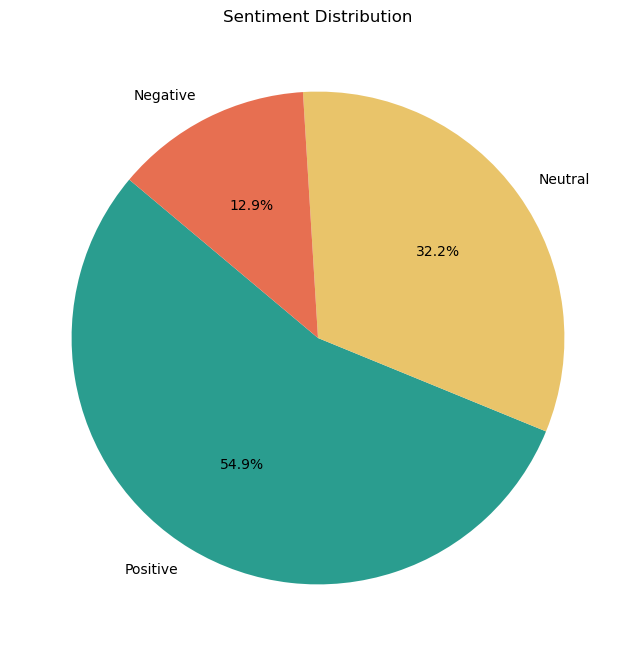

In [129]:
# Count sentiments
sentiment_counts = df['sentiment'].value_counts()
#Pie Chart
plt.figure(figsize=(8,8))
plt.pie(sentiment_counts, labels=sentiment_counts.index, autopct='%1.1f%%', startangle=140, colors=['#2a9d8f','#e9c46a','#e76f51'])
plt.title('Sentiment Distribution')
plt.show()


<h2> Sentiment Over Time</h2>

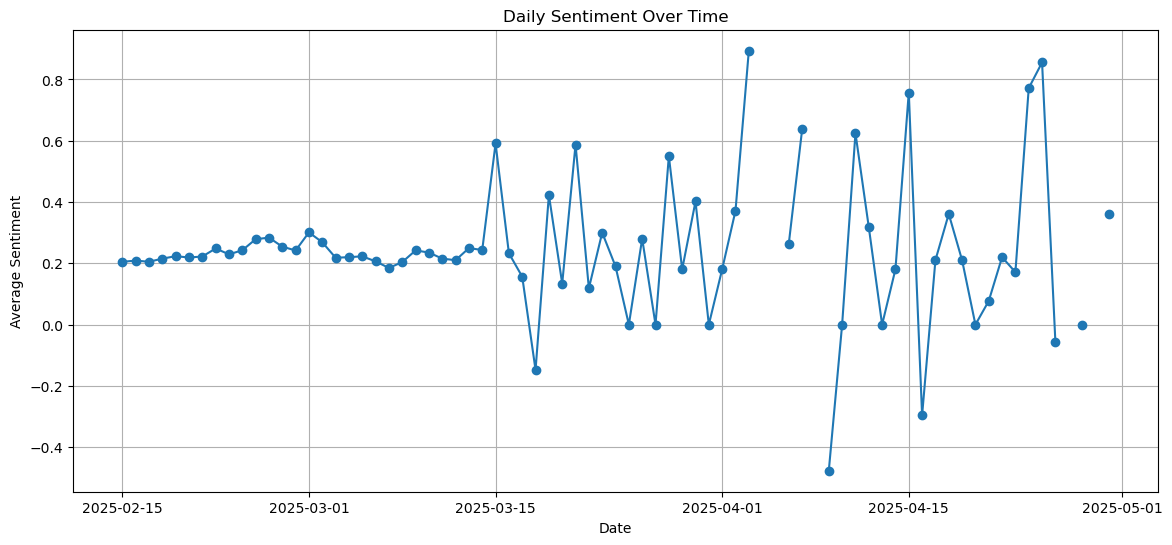

In [131]:
# Already calculated daily_tweets and weekly_tweets
# Daily Sentiment
plt.figure(figsize=(14,6))
plt.plot(daily_tweets.index, daily_tweets['vader_score'], marker='o')
plt.title('Daily Sentiment Over Time')
plt.ylabel('Average Sentiment')
plt.xlabel('Date')
plt.grid(True)
plt.show()

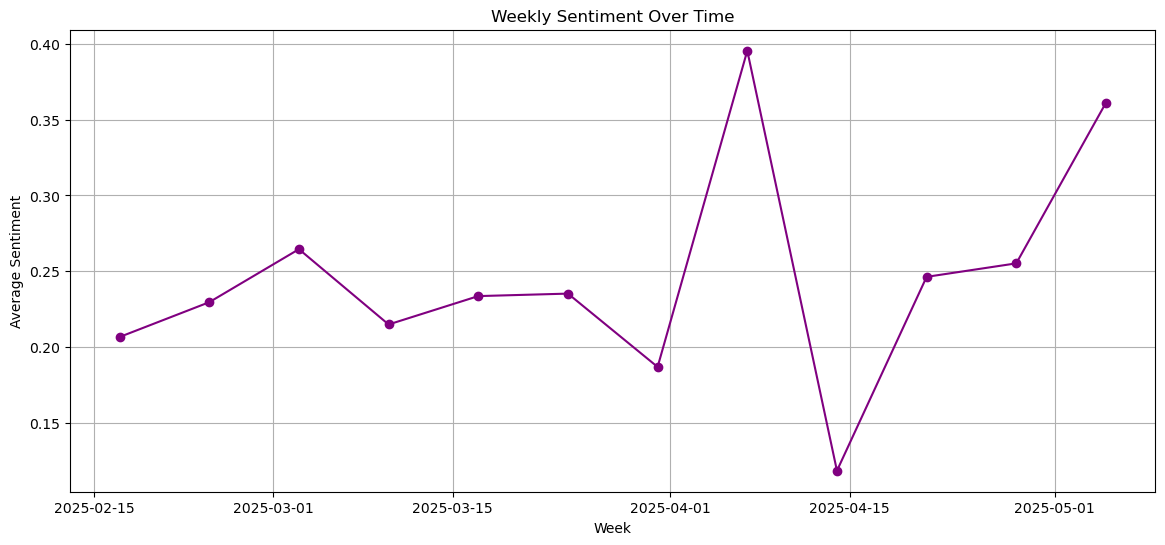

In [132]:
# Weekly Sentiment
plt.figure(figsize=(14,6))
plt.plot(weekly_tweets.index, weekly_tweets['vader_score'], marker='o', color='purple')
plt.title('Weekly Sentiment Over Time')
plt.ylabel('Average Sentiment')
plt.xlabel('Week')
plt.grid(True)
plt.show()

<h2>NLP vs CV Sentiment Comparison</h2>

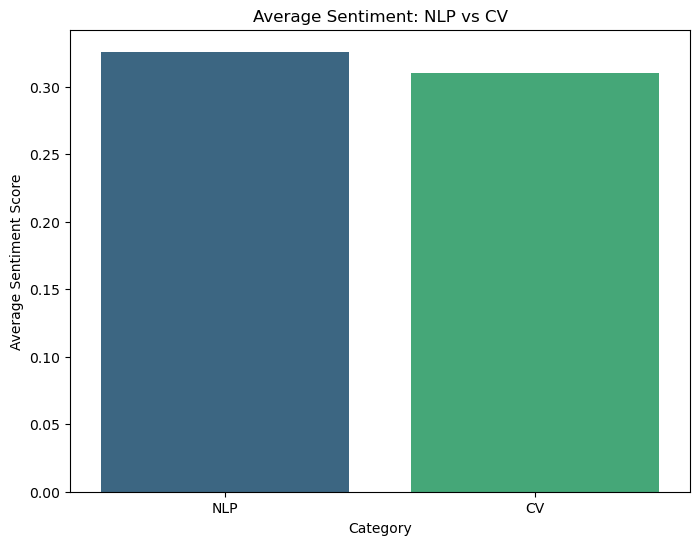

In [134]:
#Grouped Bar Chart (Average Sentiment)
# Data
sentiment_compare = {
    'Category': ['NLP', 'CV'],
    'Average_Sentiment': [
        nlp_tweets['vader_score'].mean(), 
        cv_tweets['vader_score'].mean()
    ]
}
compare_df = pd.DataFrame(sentiment_compare)

# Plot
plt.figure(figsize=(8,6))
sns.barplot(x='Category', y='Average_Sentiment', hue='Category', data=compare_df, palette='viridis', dodge=False, legend=False)
plt.title('Average Sentiment: NLP vs CV')
plt.ylabel('Average Sentiment Score')
plt.show()

<h2>Sentiment During Key Events</h2>

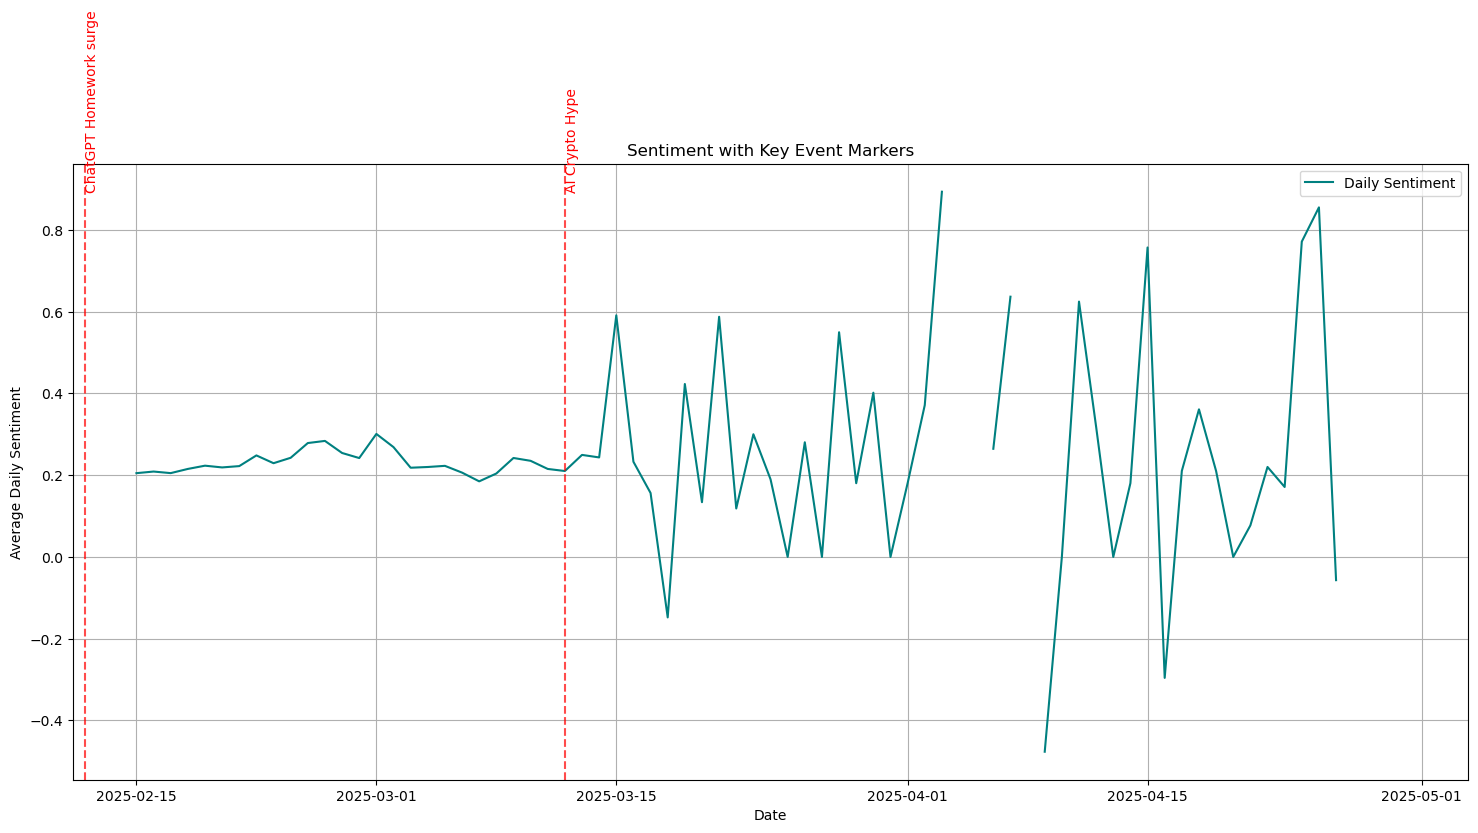

In [136]:
#Line plot + vertical annotations
# Base Daily Sentiment Line
plt.figure(figsize=(18,8))
plt.plot(daily_tweets.index, daily_tweets['vader_score'], label='Daily Sentiment', color='teal')

# Add vertical lines for each event
for event, details in events.items():
    plt.axvline(pd.to_datetime(details['Start_Date']), color='red', linestyle='--', alpha=0.7)
    plt.text(pd.to_datetime(details['Start_Date']), 0.9, event, rotation=90, color='red')

plt.title('Sentiment with Key Event Markers')
plt.ylabel('Average Daily Sentiment')
plt.xlabel('Date')
plt.legend()
plt.grid()
plt.show()


<h2>Most Frequent AI Keywords</h2>

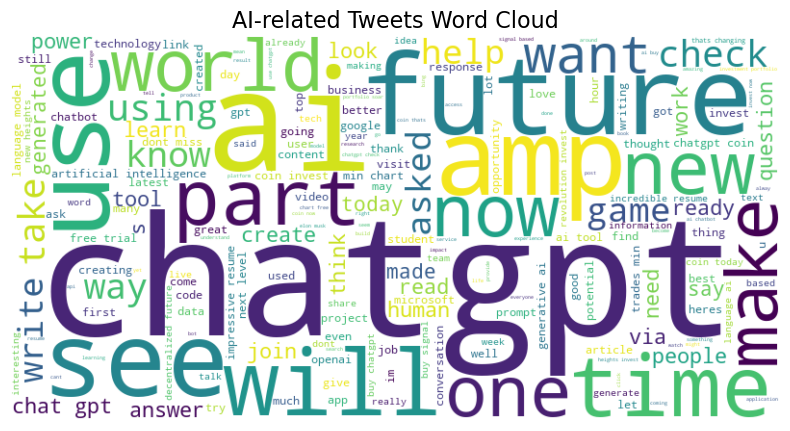

In [138]:
#Word Cloud
from wordcloud import WordCloud
from wordcloud import STOPWORDS
# Concatenate all tweets
all_text = " ".join(df['Tweet'].astype(str).tolist())

# Clean it up (basic cleaning if needed)
cleaned_text = re.sub(r"http\S+|@\S+|#\S+|[^A-Za-z\s]", "", all_text.lower())

# Generate the word cloud
stopwords = set(STOPWORDS)
wordcloud = WordCloud(width=800, height=400, background_color='white', stopwords=stopwords).generate(cleaned_text)

# Plot it
plt.figure(figsize=(10, 5))
plt.imshow(wordcloud, interpolation='bilinear')
plt.axis("off")
plt.title("AI-related Tweets Word Cloud", fontsize=16)
plt.show()


<h2>Tweet Volume Over Time</h2>

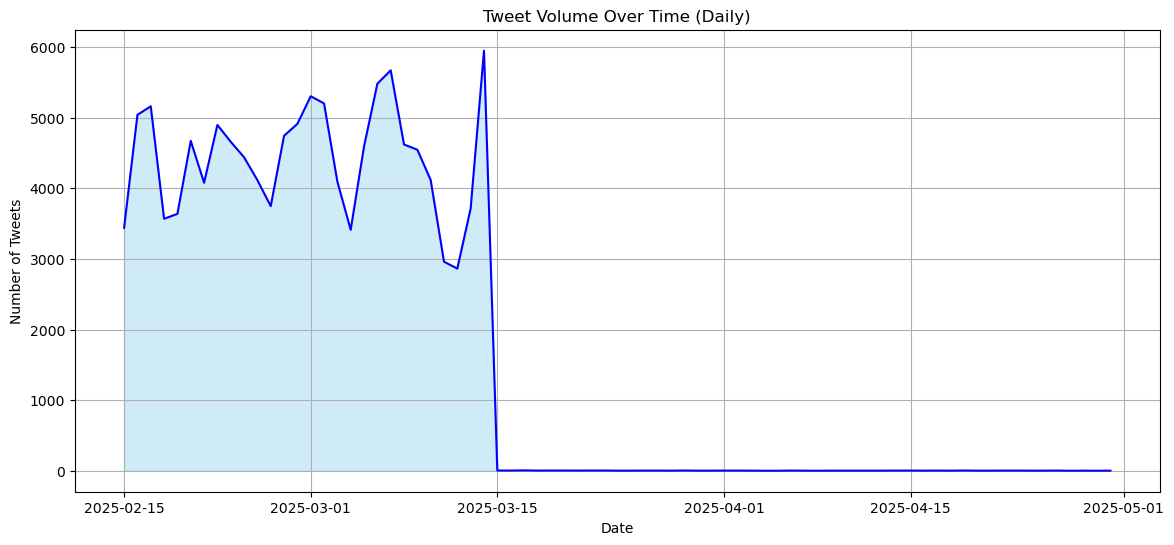

In [140]:
#Area Plot
# Daily Tweet Volume
plt.figure(figsize=(14,6))
plt.fill_between(daily_tweets.index, daily_tweets['Tweet'], color='skyblue', alpha=0.4)
plt.plot(daily_tweets.index, daily_tweets['Tweet'], color='blue')
plt.title('Tweet Volume Over Time (Daily)')
plt.ylabel('Number of Tweets')
plt.xlabel('Date')
plt.grid()
plt.show()

<h2>Sentiment by Keyword</h2>

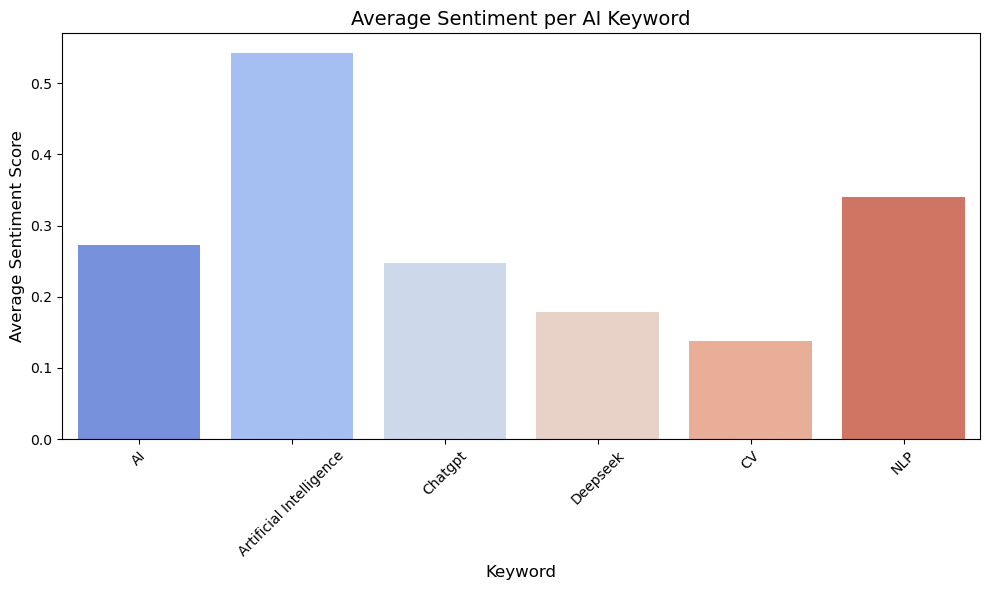

In [191]:
# Compute average sentiment per keyword
keywords = ai_keywords
keyword_sentiments = {}

for kw in keywords:
    kw_tweets = df[df['Tweet'].str.contains(kw, case=False, na=False)]
    keyword_sentiments[kw] = kw_tweets['vader_score'].mean()

# Build DataFrame
keyword_df = pd.DataFrame(keyword_sentiments.items(), columns=['Keyword', 'Avg_Sentiment'])

# Plotting
plt.figure(figsize=(10, 6))
sns.barplot(x='Keyword', y='Avg_Sentiment', data=keyword_df, palette='coolwarm', hue='Keyword', legend=False)

# Customize the plot
plt.title('Average Sentiment per AI Keyword', fontsize=14)
plt.xlabel('Keyword', fontsize=12)
plt.ylabel('Average Sentiment Score', fontsize=12)
plt.xticks(rotation=45)
plt.axhline(0, color='gray', linestyle='--', linewidth=0.8)  # Neutral sentiment line

plt.tight_layout()
plt.show()

<h2>Box Plot of Sentiment Score</h2>

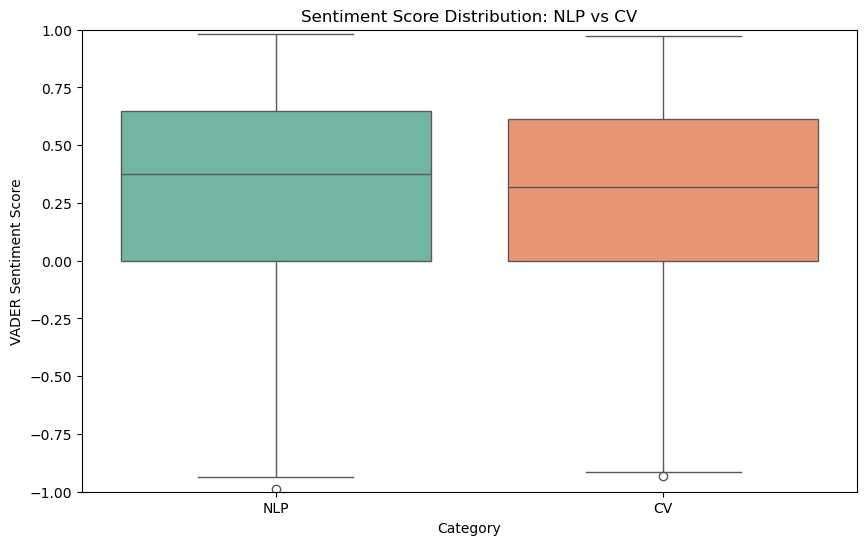

In [144]:
#Compare distribution for NLP vs CV
# Prepare Data
nlp_tweets = nlp_tweets.copy()
cv_tweets = cv_tweets.copy()

nlp_tweets['Category'] = 'NLP'
cv_tweets['Category'] = 'CV'

combined = pd.concat([nlp_tweets, cv_tweets])

# Plot
plt.figure(figsize=(10,6))
sns.boxplot(x='Category', y='vader_score', hue='Category', data=combined, palette='Set2', dodge=False, legend=False)
plt.title('Sentiment Score Distribution: NLP vs CV')
plt.ylabel('VADER Sentiment Score')
plt.ylim(-1, 1)
plt.show()


-------------